In [1]:
import sys
sys.path.append('/Users/Sakarias/QuantTrading')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging

from core.taa.optimizer import TAAOptimizer, BacktestOptimizer
from core.taa.constraints import load_constraints_from_config
from core.data.collectors.yahoo_collector import YahooCollector

# Enable logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(name)s - %(message)s')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


## 1. Load OOS Predictions from Walk-Forward Validation

In [2]:
# Load predictions for different horizons (in long format)
data_dir = Path('../../data/taa')

pred_1w_long = pd.read_csv(data_dir / 'oos_predictions_1w.csv')
pred_4w_long = pd.read_csv(data_dir / 'oos_predictions_4w.csv')
pred_12w_long = pd.read_csv(data_dir / 'oos_predictions_12w.csv')

print(f"Raw predictions loaded:")
print(f"  1-week: {pred_1w_long.shape}")
print(f"  4-week: {pred_4w_long.shape}")
print(f"  12-week: {pred_12w_long.shape}")

# Pivot to wide format: rows=dates, columns=tickers, values=predicted returns
pred_1w = pred_1w_long.pivot(index='date', columns='ticker', values='predicted')
pred_4w = pred_4w_long.pivot(index='date', columns='ticker', values='predicted')
pred_12w = pred_12w_long.pivot(index='date', columns='ticker', values='predicted')

# Convert index to datetime
pred_1w.index = pd.to_datetime(pred_1w.index)
pred_4w.index = pd.to_datetime(pred_4w.index)
pred_12w.index = pd.to_datetime(pred_12w.index)

print(f"\nPivoted predictions:")
print(f"  1-week: {pred_1w.shape}")
print(f"  4-week: {pred_4w.shape}")
print(f"  12-week: {pred_12w.shape}")

# Choose horizon for portfolio construction (4-week = monthly rebalancing)
predictions = pred_4w.copy()
print(f"\nUsing 4-week predictions for portfolio optimization")
print(f"Date range: {predictions.index.min()} to {predictions.index.max()}")
print(f"Tickers: {predictions.columns.tolist()}")
predictions.tail()


Raw predictions loaded:
  1-week: (13531, 5)
  4-week: (13516, 5)
  12-week: (13476, 5)

Pivoted predictions:
  1-week: (1504, 9)
  4-week: (1502, 9)
  12-week: (1498, 9)

Using 4-week predictions for portfolio optimization
Date range: 2015-01-02 00:00:00 to 2025-12-23 00:00:00
Tickers: ['SPY', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']


ticker,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2025-12-17,0.011272,0.016996,0.014653,0.015380,0.017776,0.021057,0.014307,0.004198,0.001590
2025-12-18,0.012938,0.022459,0.013121,0.016380,0.021696,0.031520,0.012490,0.011394,0.007985
2025-12-19,0.033128,0.033710,0.034757,0.030873,0.024659,0.040607,0.030720,0.033832,0.022951
2025-12-22,0.034460,0.035515,0.027472,0.030797,0.023966,0.041013,0.032017,0.033950,0.028294
2025-12-23,0.028288,0.032485,0.031317,0.030408,0.029654,0.039071,0.035366,NaN,NaN


## 2. Load Historical Returns for Covariance Estimation

In [3]:
# Fetch historical prices
collector = YahooCollector()
tickers = predictions.columns.tolist()

print(f"Fetching prices for tickers: {tickers}")

# Fetch from 2010 to cover full prediction period
prices = collector.fetch_history(
    tickers=tickers,
    start_date='2010-01-01',
    end_date='2025-12-29'
)

print(f"Raw prices shape: {prices.shape}")
print(f"Price levels: {prices.columns.get_level_values('Price').unique().tolist()}")
print(f"Tickers in prices: {prices.columns.get_level_values('Ticker').unique().tolist()}")

# Extract Close prices - handle MultiIndex properly
if isinstance(prices.columns, pd.MultiIndex):
    # Check which level has tickers
    if 'Ticker' in prices.columns.names:
        close_prices = prices.xs('Close', level='Price', axis=1)
    else:
        # Might be (Price, Ticker) instead of (Ticker, Price)
        try:
            close_prices = prices.xs('Close', level=0, axis=1)
        except:
            close_prices = prices.xs('Close', level=1, axis=1)
else:
    # Not a MultiIndex, assume all columns are tickers
    close_prices = prices

print(f"Close prices shape: {close_prices.shape}")
print(f"Close prices columns: {close_prices.columns.tolist()}")
print(f"Close prices has data: {not close_prices.empty}")
print(f"First few rows:\n{close_prices.head()}")

# Calculate daily returns
returns = close_prices.pct_change().dropna()
print(f"\nReturns shape: {returns.shape}")
print(f"Returns has data: {len(returns) > 0}")
if len(returns) > 0:
    print(f"Date range: {returns.index.min()} to {returns.index.max()}")
    print(f"Returns columns: {returns.columns.tolist()}")
else:
    print("WARNING: Returns DataFrame is empty!")


INFO - core.data.collectors.yahoo_collector - Fetching 1d data for 9 tickers from 2010-01-01 to 2025-12-29


Fetching prices for tickers: ['SPY', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
Raw prices shape: (4021, 45)
Price levels: ['Open', 'High', 'Low', 'Close', 'Volume']
Tickers in prices: ['XLV', 'XLE', 'XLI', 'XLU', 'XLK', 'XLF', 'SPY', 'XLP', 'XLY']
Close prices shape: (4021, 9)
Close prices columns: ['XLV', 'XLE', 'XLI', 'XLU', 'XLK', 'XLF', 'SPY', 'XLP', 'XLY']
Close prices has data: True
First few rows:
Ticker            XLV        XLE        XLI       XLU       XLK       XLF  \
Date                                                                        
2010-01-04  24.083448  17.381090  20.981579  8.948220  9.390444  8.988356   
2010-01-05  23.847261  17.522957  21.055666  8.841696  9.378339  9.153560   
2010-01-06  24.091066  17.732792  21.100122  8.893519  9.273416  9.171914   
2010-01-07  24.174877  17.706190  21.329788  8.853207  9.237100  9.367714   
2010-01-08  24.212971  17.821463  21.670593  8.844571  9.297627  9.312649   

Ticker            SPY        XLP      

## 3. Load Constraints from Config

In [4]:
# Load optimization constraints
constraints = load_constraints_from_config('../../config/taa_constraints.yaml')

print("=" * 60)
print("OPTIMIZATION CONSTRAINTS")
print("=" * 60)
print(f"\nPosition Limits:")
print(f"  - Long only: {constraints.position.long_only}")
print(f"  - Max position: {constraints.position.max_position*100:.0f}%")
print(f"  - Min position: {constraints.position.min_position*100:.0f}%")

print(f"\nTracking Error:")
print(f"  - Max TE: {constraints.tracking_error.max_te*100:.1f}%")
print(f"  - Benchmark: ACWI")

print(f"\nTurnover:")
print(f"  - Max monthly: {constraints.turnover.max_monthly*100:.0f}%")
print(f"  - Penalty lambda: {constraints.turnover.penalty_lambda}")

print(f"\nRisk Aversion: {constraints.risk_aversion}")
print("=" * 60)


OPTIMIZATION CONSTRAINTS

Position Limits:
  - Long only: True
  - Max position: 40%
  - Min position: 0%

Tracking Error:
  - Max TE: 12.0%
  - Benchmark: ACWI

Turnover:
  - Max monthly: 25%
  - Penalty lambda: 0.0005

Risk Aversion: 1.0


## 4. Initialize Optimizer and Run Backtest

### Debug: Check Data Alignment

In [5]:
# Initialize optimizer
optimizer = TAAOptimizer(constraints)

# Backtest optimizer with weekly rebalancing
backtest_optimizer = BacktestOptimizer(
    optimizer=optimizer,
    lookback_days=252,  # 1 year for covariance estimation
    rebalance_freq='W'  # Weekly rebalancing
)

print("Running backtest optimization...")
print(f"Rebalance frequency: Weekly")
print(f"Covariance lookback: 252 days")

# Run backtest
portfolio_weights = backtest_optimizer.run_backtest(
    predictions_df=predictions,
    returns_df=returns,
    vix_series=None  # TODO: Add VIX for transaction cost adjustment
)

print(f"\nBacktest complete!")
print(f"Portfolio weights shape: {portfolio_weights.shape}")
print(f"Date range: {portfolio_weights.index.min()} to {portfolio_weights.index.max()}")
portfolio_weights.tail(10)

INFO - core.taa.optimizer - Starting backtest: 1502 prediction dates, 4020 return dates
INFO - core.taa.optimizer - Predictions range: 2015-01-02 00:00:00 to 2025-12-23 00:00:00
INFO - core.taa.optimizer - Returns range: 2010-01-05 00:00:00 to 2025-12-26 00:00:00
INFO - core.taa.optimizer - Predictions range: 2015-01-02 00:00:00 to 2025-12-23 00:00:00
INFO - core.taa.optimizer - Returns range: 2010-01-05 00:00:00 to 2025-12-26 00:00:00
INFO - core.taa.optimizer - Rebalance dates (W): 314 dates
INFO - core.taa.optimizer - Processing first rebalance date: 2015-01-04 00:00:00
INFO - core.taa.optimizer - Rebalance dates (W): 314 dates
INFO - core.taa.optimizer - Processing first rebalance date: 2015-01-04 00:00:00
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=-0.0035, Vol=1.6317, Turnover=0.2500
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=-0.0035, Vol=1.6317, Turnover=0.2500
INFO - core.taa.optimizer - Optimization success

Running backtest optimization...
Rebalance frequency: Weekly
Covariance lookback: 252 days


INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0331, Vol=1.6971, Turnover=0.2500
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0074, Vol=1.7568, Turnover=0.2500
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0074, Vol=1.7568, Turnover=0.2500
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0142, Vol=1.8950, Turnover=0.2340
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0183, Vol=1.8346, Turnover=0.2500
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0142, Vol=1.8950, Turnover=0.2340
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0183, Vol=1.8346, Turnover=0.2500
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0.0043, Vol=1.8363, Turnover=0.2500
INFO - core.taa.optimizer - Optimization successful (solver: CLARABEL): Return=0


Backtest complete!
Portfolio weights shape: (314, 16)
Date range: 2015-01-04 00:00:00 to 2025-12-28 00:00:00


,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,meta_status,meta_solver_status,meta_objective_value,meta_expected_return,meta_volatility,meta_turnover,meta_tracking_error
Date,,,,,,,,,,,,,,,,
2025-10-26,1.653303e-02,9.722816e-02,1.483244e-09,2.280314e-02,8.357310e-10,0.4,0.201179,0.235223,2.703323e-02,optimal,CLARABEL: optimal,0.006152,0.025586,2.199938,0.175750,1.904941
2025-11-02,1.653301e-02,1.039636e-01,6.061022e-10,4.801702e-02,2.417247e-10,0.4,0.201159,0.230327,1.976075e-09,optimal,CLARABEL: optimal,0.001627,0.020978,2.203492,0.063899,1.904941
2025-11-09,2.247424e-10,1.462178e-02,8.418597e-10,1.006953e-01,5.071946e-02,0.4,0.201159,0.232804,5.146531e-10,optimal,CLARABEL: optimal,0.000934,0.020214,2.188367,0.211750,1.813859
2025-11-16,4.097219e-09,1.462158e-02,6.219891e-09,2.641493e-02,2.200332e-08,0.4,0.238112,0.232804,8.804683e-02,optimal,CLARABEL: optimal,-0.009137,0.009878,2.170195,0.250000,1.891591
2025-11-23,1.157982e-09,8.133935e-08,1.623347e-09,2.169723e-09,1.250000e-01,0.4,0.199663,0.187290,8.804683e-02,optimal,CLARABEL: optimal,-0.028229,-0.008294,2.222997,0.250000,1.496984
2025-11-30,7.077435e-09,4.810111e-08,1.831187e-08,1.352363e-08,8.900559e-02,0.4,0.324660,0.186334,3.621358e-08,optimal,CLARABEL: optimal,0.000015,0.018175,2.120007,0.249995,1.904938
2025-12-07,4.880163e-09,7.312529e-02,2.565542e-08,7.516588e-07,8.900813e-02,0.4,0.324662,0.113204,5.003480e-09,optimal,CLARABEL: optimal,0.006798,0.025060,2.134040,0.146260,1.737325
2025-12-14,3.220364e-02,1.659215e-01,7.846942e-08,7.481090e-07,9.275159e-05,0.4,0.324661,0.077120,5.700405e-09,optimal,CLARABEL: optimal,0.006694,0.020410,1.836959,0.250000,1.761369
2025-12-21,1.572031e-01,1.659214e-01,1.521195e-07,6.522834e-07,9.261109e-05,0.4,0.199662,0.077120,7.393457e-09,optimal,CLARABEL: optimal,0.027069,0.035789,1.454506,0.249999,1.341228


## 5. Calculate Portfolio Returns

In [6]:
# Extract weight columns (exclude metadata)
weight_cols = [col for col in portfolio_weights.columns if not col.startswith('meta_')]
weights_only = portfolio_weights[weight_cols]

# Align weights with returns (forward-fill weights to daily frequency)
daily_weights = weights_only.reindex(returns.index, method='ffill').fillna(0)

# Calculate portfolio returns
portfolio_returns = (daily_weights.shift(1) * returns[weight_cols]).sum(axis=1)
portfolio_returns = portfolio_returns.dropna()

print(f"Portfolio returns shape: {portfolio_returns.shape}")
print(f"Date range: {portfolio_returns.index.min()} to {portfolio_returns.index.max()}")

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()
print(f"\nTotal return: {(cumulative_returns.iloc[-1] - 1)*100:.2f}%")

Portfolio returns shape: (4020,)
Date range: 2010-01-05 00:00:00 to 2025-12-26 00:00:00

Total return: 160.57%


In [7]:
# Get prediction start date for fair comparison
prediction_start = predictions.index.min()

# Fetch SPX (S&P 500 Index) benchmark - ALIGNED TO PREDICTION START DATE (not historical data start)
benchmark_prices = collector.fetch_history(
    tickers=['^GSPC'],  # Yahoo Finance ticker for S&P 500 Index
    start_date=prediction_start.strftime('%Y-%m-%d'),
    end_date=portfolio_returns.index.max().strftime('%Y-%m-%d')
)

benchmark_close = benchmark_prices.xs('Close', level='Price', axis=1)['^GSPC']
benchmark_returns = benchmark_close.pct_change().dropna()

# Trim portfolio returns to match prediction start (fair comparison)
# Portfolio returns may start earlier due to historical data for covariance estimation
portfolio_returns = portfolio_returns.loc[portfolio_returns.index >= prediction_start]

# Align benchmark with portfolio (same date range)
benchmark_returns = benchmark_returns.reindex(portfolio_returns.index).fillna(0)

# Recalculate cumulative returns with aligned data
cumulative_returns = (1 + portfolio_returns).cumprod()
benchmark_cumulative = (1 + benchmark_returns).cumprod()

print(f"✓ Fair comparison period established:")
print(f"  Prediction start: {prediction_start.strftime('%Y-%m-%d')}")
print(f"  Portfolio returns: {len(portfolio_returns)} days ({portfolio_returns.index.min().strftime('%Y-%m-%d')} to {portfolio_returns.index.max().strftime('%Y-%m-%d')})")
print(f"  Benchmark returns: {len(benchmark_returns)} days ({benchmark_returns.index.min().strftime('%Y-%m-%d')} to {benchmark_returns.index.max().strftime('%Y-%m-%d')})")
print(f"  Lengths match: {len(portfolio_returns) == len(benchmark_returns)}")
print(f"\nPortfolio total return: {(cumulative_returns.iloc[-1] - 1)*100:.2f}%")
print(f"Benchmark total return: {(benchmark_cumulative.iloc[-1] - 1)*100:.2f}%")

INFO - core.data.collectors.yahoo_collector - Fetching 1d data for 1 tickers from 2015-01-02 to 2025-12-26


✓ Fair comparison period established:
  Prediction start: 2015-01-02
  Portfolio returns: 2763 days (2015-01-02 to 2025-12-26)
  Benchmark returns: 2763 days (2015-01-02 to 2025-12-26)
  Lengths match: True

Portfolio total return: 160.57%
Benchmark total return: 236.80%


## 7. Performance Metrics

In [8]:
def calculate_metrics(returns: pd.Series, name: str) -> dict:
    """
    Calculate performance metrics.
    """
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    
    # CAGR
    years = (returns.index[-1] - returns.index[0]).days / 365.25
    cagr = (1 + total_return) ** (1 / years) - 1
    
    # Sharpe (2% risk-free rate)
    excess_returns = returns - 0.02 / 252
    sharpe = np.sqrt(252) * excess_returns.mean() / returns.std()
    
    # Volatility
    volatility = returns.std() * np.sqrt(252)
    
    # Max drawdown
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return {
        'Strategy': name,
        'Total Return': f"{total_return*100:.2f}%",
        'CAGR': f"{cagr*100:.2f}%",
        'Volatility': f"{volatility*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.3f}",
        'Max Drawdown': f"{max_drawdown*100:.2f}%"
    }

# Calculate metrics
portfolio_metrics = calculate_metrics(portfolio_returns, 'TAA Portfolio')
benchmark_metrics = calculate_metrics(benchmark_returns, 'ACWI Benchmark')

# Display comparison
comparison = pd.DataFrame([portfolio_metrics, benchmark_metrics]).set_index('Strategy')
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(comparison.to_string())
print("="*80)


PERFORMANCE COMPARISON
               Total Return    CAGR Volatility Sharpe Ratio Max Drawdown
Strategy                                                                
TAA Portfolio       160.57%   9.11%     15.78%        0.506      -32.67%
ACWI Benchmark      236.80%  11.69%     17.91%        0.597      -33.92%


## 8. Equity Curve Visualization

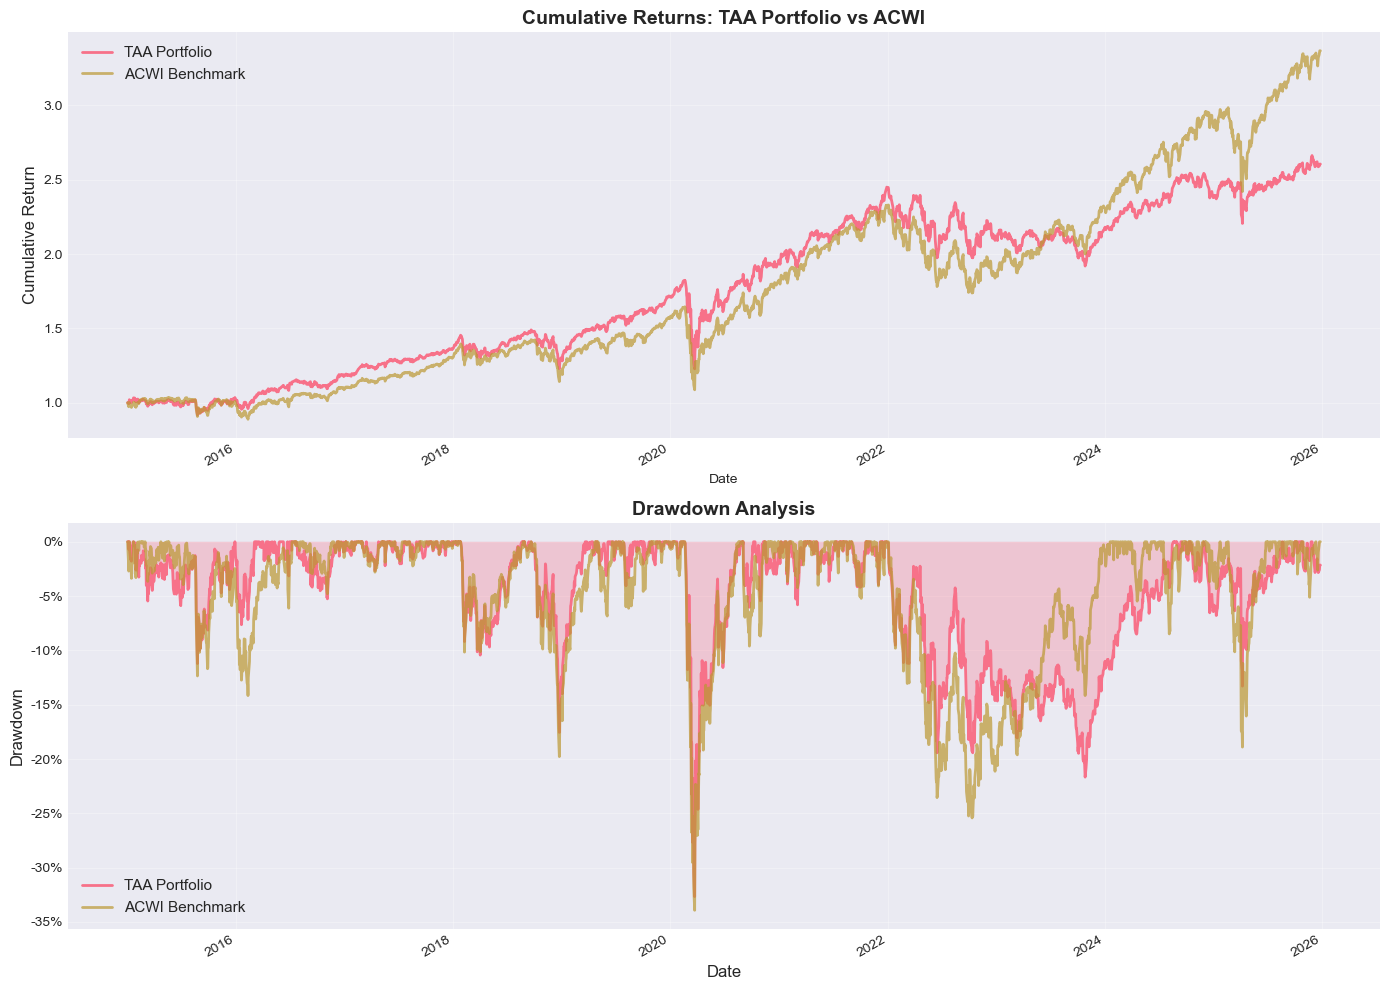

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0]
cumulative_returns.plot(ax=ax1, label='TAA Portfolio', linewidth=2)
benchmark_cumulative.plot(ax=ax1, label='ACWI Benchmark', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Returns: TAA Portfolio vs ACWI', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[1]
portfolio_rolling_max = cumulative_returns.expanding().max()
portfolio_drawdown = (cumulative_returns - portfolio_rolling_max) / portfolio_rolling_max

benchmark_rolling_max = benchmark_cumulative.expanding().max()
benchmark_drawdown = (benchmark_cumulative - benchmark_rolling_max) / benchmark_rolling_max

portfolio_drawdown.plot(ax=ax2, label='TAA Portfolio', linewidth=2, color='C0')
benchmark_drawdown.plot(ax=ax2, label='ACWI Benchmark', linewidth=2, alpha=0.7, color='C1')
ax2.fill_between(portfolio_drawdown.index, portfolio_drawdown, 0, alpha=0.3)
ax2.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

plt.tight_layout()
plt.show()

## 9. Rolling Sharpe Ratio

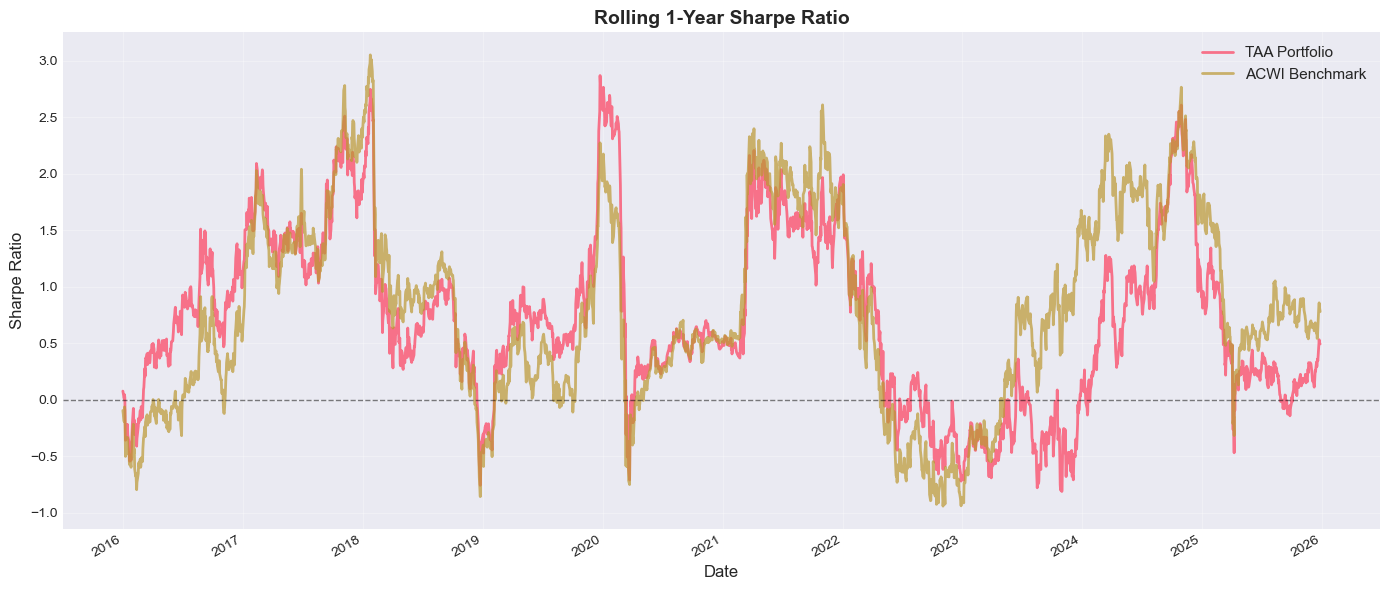

In [10]:
# Calculate rolling 252-day Sharpe
window = 252
portfolio_excess = portfolio_returns - 0.02 / 252
benchmark_excess = benchmark_returns - 0.02 / 252

portfolio_rolling_sharpe = (
    np.sqrt(252) * portfolio_excess.rolling(window).mean() / portfolio_returns.rolling(window).std()
)
benchmark_rolling_sharpe = (
    np.sqrt(252) * benchmark_excess.rolling(window).mean() / benchmark_returns.rolling(window).std()
)

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_rolling_sharpe.plot(ax=ax, label='TAA Portfolio', linewidth=2)
benchmark_rolling_sharpe.plot(ax=ax, label='ACWI Benchmark', linewidth=2, alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('Rolling 1-Year Sharpe Ratio', fontsize=14, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Portfolio Weights Heatmap

/var/folders/nz/j4jbvftx68bd6h7_50gvnh180000gn/T/ipykernel_42275/2728112295.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_weights = weights_only.resample('M').last()


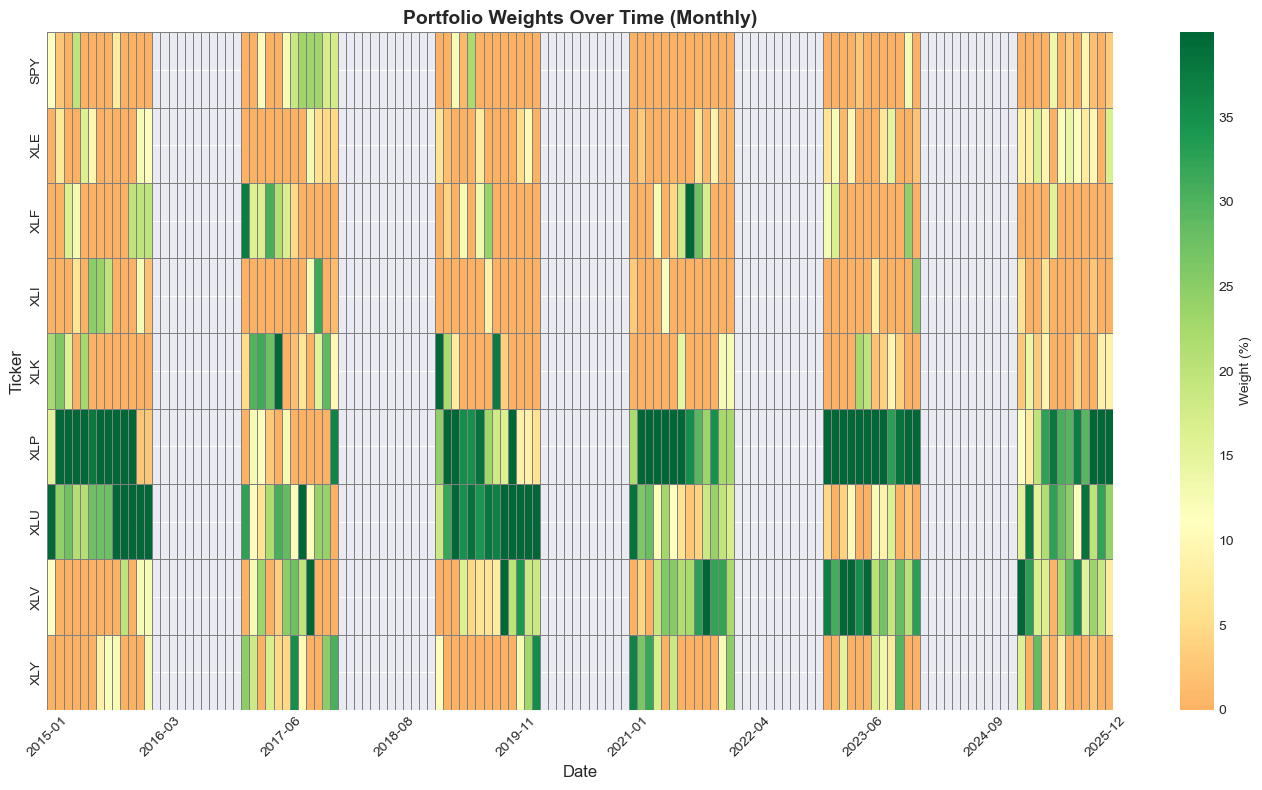

In [11]:
# Resample weights to monthly for cleaner visualization
monthly_weights = weights_only.resample('M').last()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    monthly_weights.T * 100,  # Convert to percentages
    cmap='RdYlGn',
    center=100/len(weight_cols),  # Equal weight as neutral
    cbar_kws={'label': 'Weight (%)'},
    ax=ax,
    linewidths=0.5,
    linecolor='gray'
)
ax.set_title('Portfolio Weights Over Time (Monthly)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ticker', fontsize=12)

# Format x-axis to show fewer labels
n_ticks = 10
tick_positions = np.linspace(0, len(monthly_weights) - 1, n_ticks, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([monthly_weights.index[i].strftime('%Y-%m') for i in tick_positions], rotation=45)

plt.tight_layout()
plt.show()

## 11. Turnover Analysis

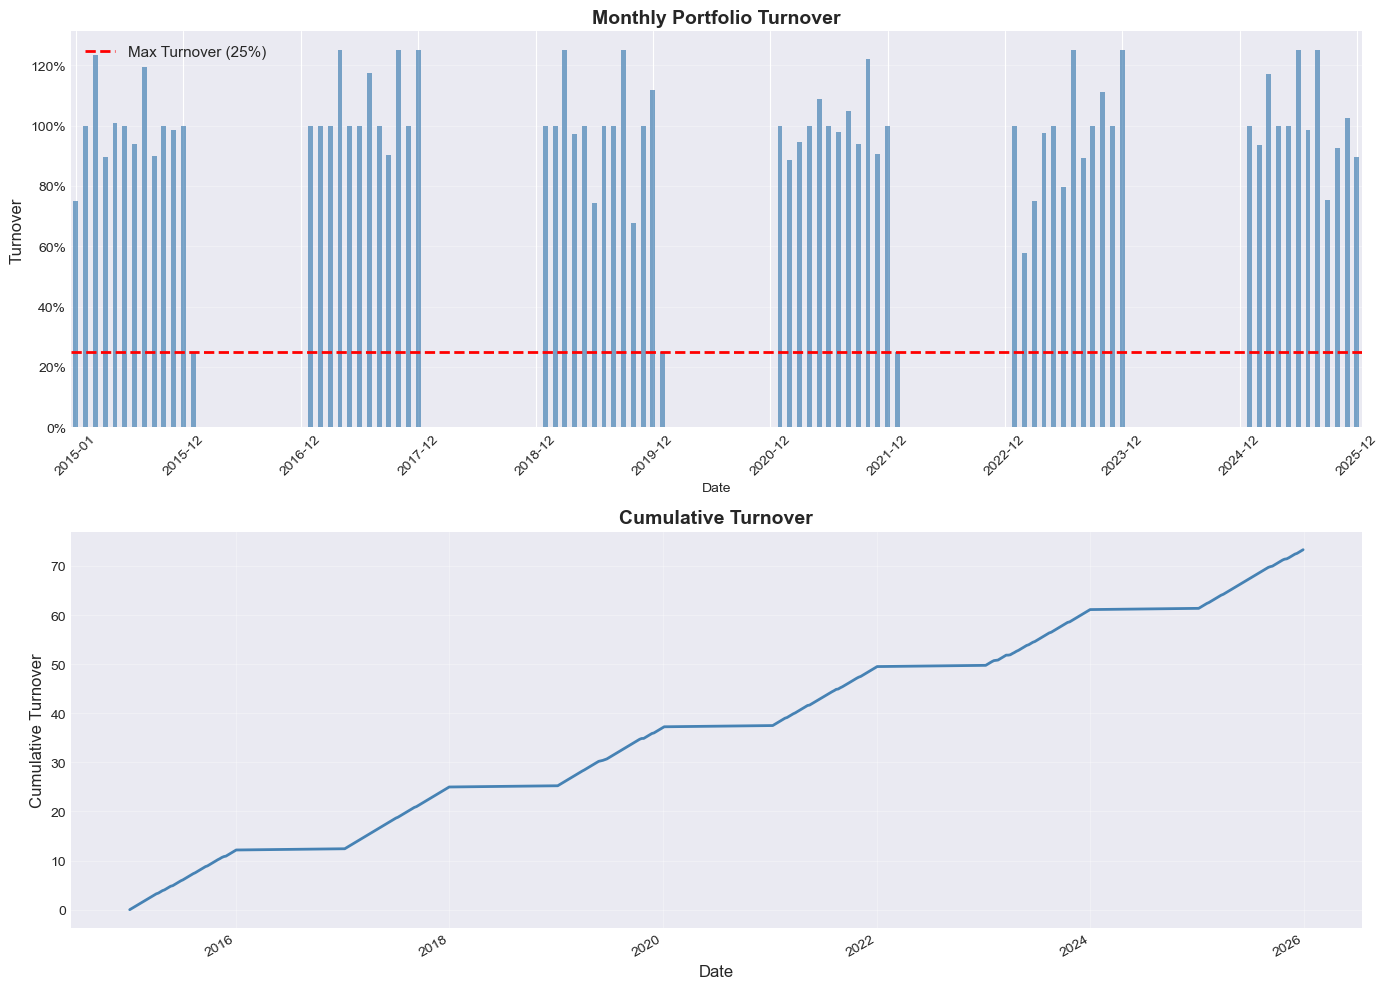


Average monthly turnover: 55.53%
Max monthly turnover: 125.00%
Total cumulative turnover: 73.30


In [12]:
# Calculate turnover from weight changes
weight_changes = weights_only.diff().abs().sum(axis=1)
monthly_turnover = weight_changes.resample('ME').sum()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Monthly turnover
ax1 = axes[0]
monthly_turnover.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.axhline(
    constraints.turnover.max_monthly, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Max Turnover ({constraints.turnover.max_monthly*100:.0f}%)'
)
ax1.set_title('Monthly Portfolio Turnover', fontsize=14, fontweight='bold')
ax1.set_ylabel('Turnover', fontsize=12)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Limit x-axis labels
n_labels = 12
label_indices = np.linspace(0, len(monthly_turnover) - 1, n_labels, dtype=int)
ax1.set_xticks(label_indices)
ax1.set_xticklabels([monthly_turnover.index[i].strftime('%Y-%m') for i in label_indices], rotation=45)

# Cumulative turnover
ax2 = axes[1]
cumulative_turnover = weight_changes.cumsum()
cumulative_turnover.plot(ax=ax2, linewidth=2, color='steelblue')
ax2.set_title('Cumulative Turnover', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Turnover', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage monthly turnover: {monthly_turnover.mean()*100:.2f}%")
print(f"Max monthly turnover: {monthly_turnover.max()*100:.2f}%")
print(f"Total cumulative turnover: {cumulative_turnover.iloc[-1]:.2f}")

## 12. Tracking Error Analysis

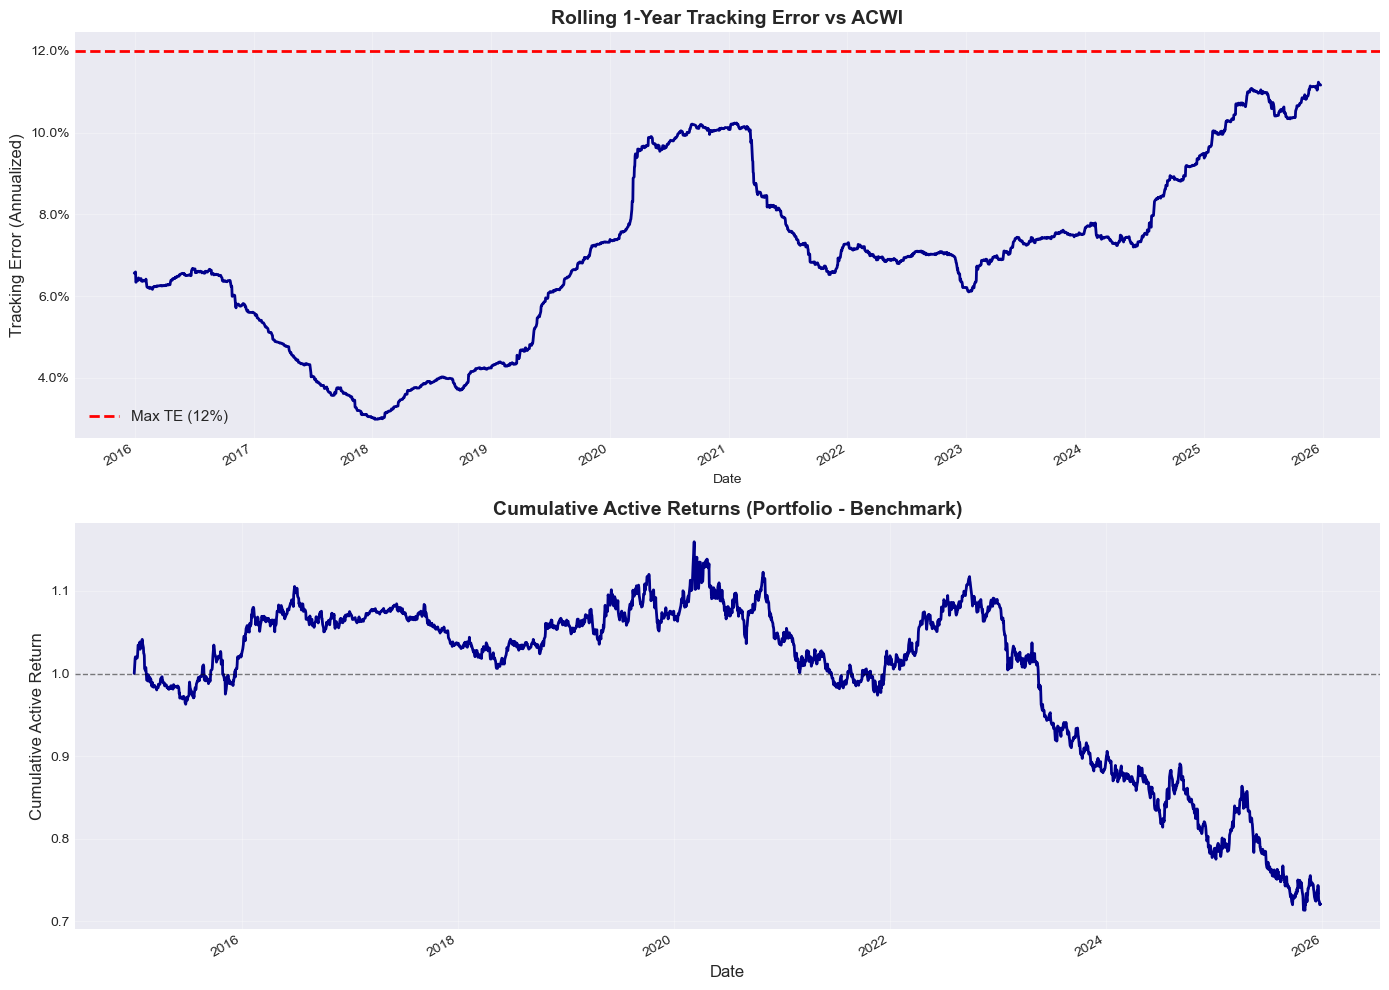


Realized Tracking Error: 7.52%
Information Ratio: -0.360
Alpha (annualized): -2.70%


In [13]:
# Calculate active returns
active_returns = portfolio_returns - benchmark_returns

# Rolling tracking error (252-day window)
rolling_te = active_returns.rolling(252).std() * np.sqrt(252)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling tracking error
ax1 = axes[0]
rolling_te.plot(ax=ax1, linewidth=2, color='darkblue')
ax1.axhline(
    constraints.tracking_error.max_te, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Max TE ({constraints.tracking_error.max_te*100:.0f}%)'
)
ax1.set_title('Rolling 1-Year Tracking Error vs ACWI', fontsize=14, fontweight='bold')
ax1.set_ylabel('Tracking Error (Annualized)', fontsize=12)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Cumulative active returns
ax2 = axes[1]
cumulative_active = (1 + active_returns).cumprod()
cumulative_active.plot(ax=ax2, linewidth=2, color='darkblue')
ax2.axhline(1, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_title('Cumulative Active Returns (Portfolio - Benchmark)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Active Return', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate realized tracking error
realized_te = active_returns.std() * np.sqrt(252)
information_ratio = (active_returns.mean() * 252) / realized_te

print(f"\nRealized Tracking Error: {realized_te*100:.2f}%")
print(f"Information Ratio: {information_ratio:.3f}")
print(f"Alpha (annualized): {active_returns.mean() * 252 * 100:.2f}%")

## 13. Transaction Cost Impact

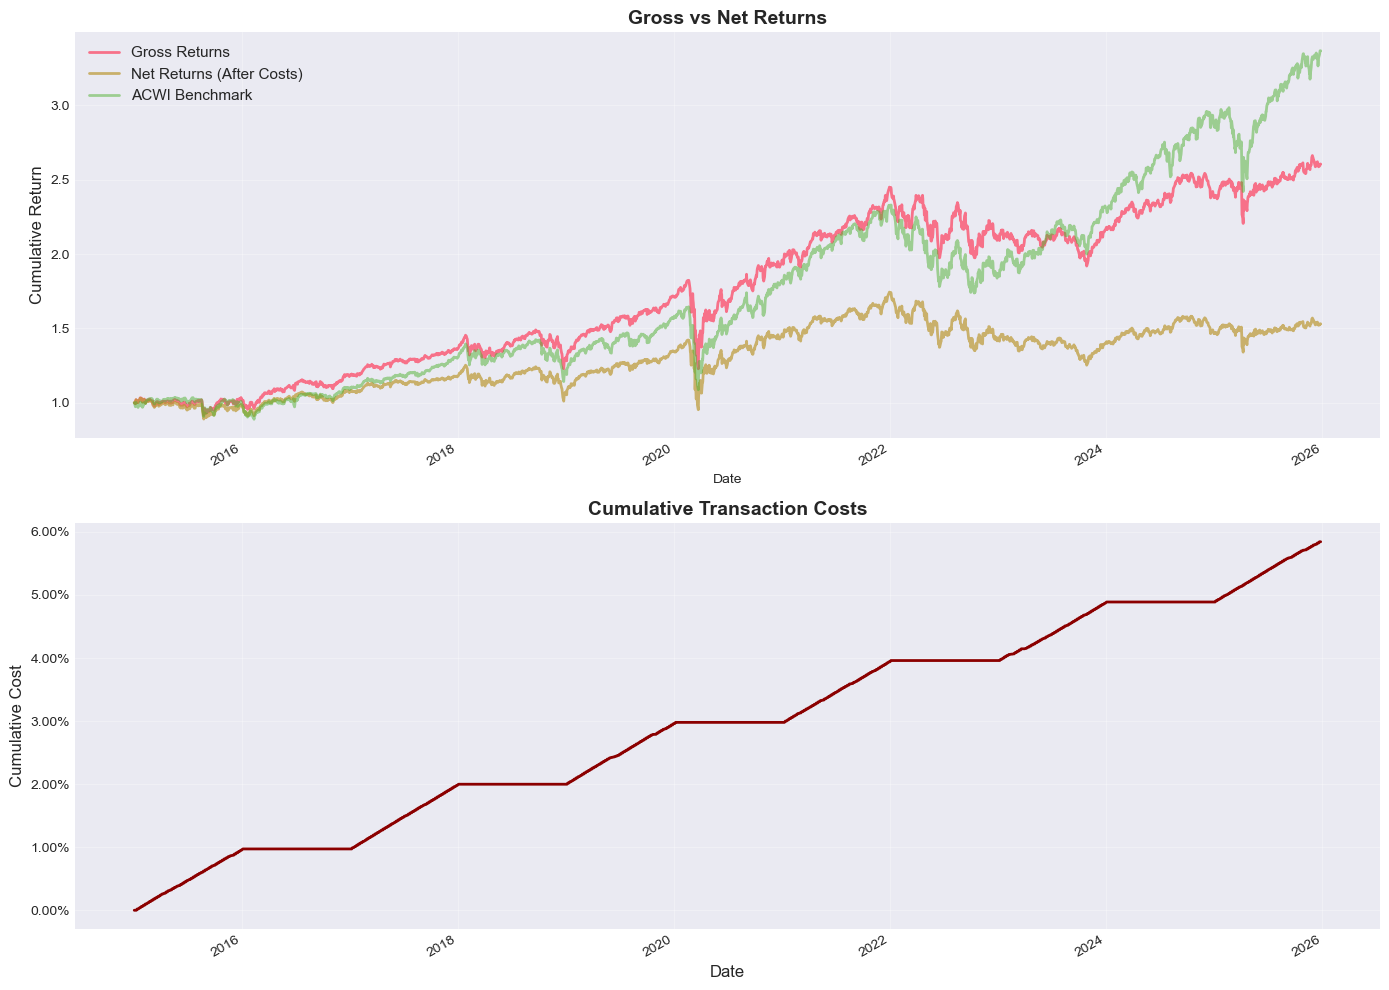


NET PERFORMANCE (After Transaction Costs)
                    Total Return    CAGR Volatility Sharpe Ratio Max Drawdown
Strategy                                                                     
TAA Portfolio            160.57%   9.11%     15.78%        0.506      -32.67%
TAA Portfolio (Net)       53.08%   3.95%     15.78%        0.198      -32.99%
ACWI Benchmark           236.80%  11.69%     17.91%        0.597      -33.92%

Total transaction costs: 5.84%
Annualized cost drag: 0.53%


In [14]:
# Calculate transaction costs
tc_bps = constraints.transaction_costs.commission_bps + constraints.transaction_costs.slippage_bps
tc_rate = tc_bps / 10000

# Turnover-based costs (weekly)
turnover_costs_weekly = weight_changes * tc_rate

# Align turnover costs with daily returns (forward-fill to daily frequency)
# Transaction costs are incurred on rebalance dates, then amortized daily
turnover_costs = turnover_costs_weekly.reindex(portfolio_returns.index, method='ffill').fillna(0)

# Net returns after costs
net_returns = portfolio_returns - turnover_costs
net_cumulative = (1 + net_returns).cumprod()

# Calculate cumulative costs for reporting (from weekly data)
cumulative_costs_weekly = turnover_costs_weekly.cumsum()
cumulative_costs = cumulative_costs_weekly.reindex(portfolio_returns.index, method='ffill').fillna(0)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gross vs Net returns
ax1 = axes[0]
cumulative_returns.plot(ax=ax1, label='Gross Returns', linewidth=2)
net_cumulative.plot(ax=ax1, label='Net Returns (After Costs)', linewidth=2, alpha=0.7)
benchmark_cumulative.plot(ax=ax1, label='ACWI Benchmark', linewidth=2, alpha=0.5)
ax1.set_title('Gross vs Net Returns', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Cumulative costs
ax2 = axes[1]
cumulative_costs.plot(ax=ax2, linewidth=2, color='darkred')
ax2.set_title('Cumulative Transaction Costs', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Cost', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.2f}%'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate net metrics
net_metrics = calculate_metrics(net_returns, 'TAA Portfolio (Net)')
print("\n" + "="*80)
print("NET PERFORMANCE (After Transaction Costs)")
print("="*80)
net_comparison = pd.DataFrame([portfolio_metrics, net_metrics, benchmark_metrics]).set_index('Strategy')
print(net_comparison.to_string())
print("="*80)
print(f"\nTotal transaction costs: {cumulative_costs.iloc[-1]*100:.2f}%")
print(f"Annualized cost drag: {(cumulative_costs.iloc[-1] / ((net_returns.index[-1] - net_returns.index[0]).days / 365.25))*100:.2f}%")

## 14. Save Results

In [15]:
# Create results directory
results_dir = Path('../../data/taa/backtest_results')
results_dir.mkdir(parents=True, exist_ok=True)

# Save portfolio weights
portfolio_weights.to_csv(results_dir / 'portfolio_weights.csv')
print(f"Saved portfolio weights to {results_dir / 'portfolio_weights.csv'}")

# Save returns
returns_df = pd.DataFrame({
    'Portfolio_Gross': portfolio_returns,
    'Portfolio_Net': net_returns,
    'Benchmark': benchmark_returns,
    'Active': active_returns
})
returns_df.to_csv(results_dir / 'returns.csv')
print(f"Saved returns to {results_dir / 'returns.csv'}")

# Save metrics
metrics_df = pd.DataFrame([portfolio_metrics, net_metrics, benchmark_metrics]).set_index('Strategy')
metrics_df.to_csv(results_dir / 'performance_metrics.csv')
print(f"Saved metrics to {results_dir / 'performance_metrics.csv'}")

print("\n✅ Backtest complete! Results saved.")


Saved portfolio weights to ../../data/taa/backtest_results/portfolio_weights.csv
Saved returns to ../../data/taa/backtest_results/returns.csv
Saved metrics to ../../data/taa/backtest_results/performance_metrics.csv

✅ Backtest complete! Results saved.
